## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [2]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.0.0


In [3]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
# Imports here
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets

# Define transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32)
}

# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Device: {device}")

# Print information about dataloaders
for phase in ['train', 'valid', 'test']:
    print(f"{phase.capitalize()} DataLoader - Number of batches: {len(dataloaders[phase])}")
    print(f"{phase.capitalize()} DataLoader - Total images: {len(image_datasets[phase])}")

Device: cuda
Train DataLoader - Number of batches: 205
Train DataLoader - Total images: 6552
Valid DataLoader - Number of batches: 26
Valid DataLoader - Total images: 818
Test DataLoader - Number of batches: 26
Test DataLoader - Total images: 819


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# Print some information about the loaded JSON object
print(f"Number of items in cat_to_name: {len(cat_to_name)}")

# Print a few examples from the loaded JSON object
examples = {k: cat_to_name[k] for k in list(cat_to_name)[:3]}  # Get the first 3 items as examples
print(f"Some examples from cat_to_name: {examples}")


Number of items in cat_to_name: 102
Some examples from cat_to_name: {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue'}


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# TODO: Build and train your network
# Load a pre-trained model
print("Loading a pre-trained model: VGG16")
model = models.vgg16(pretrained=True)

print("Freezing the parameters of the pre-trained model")
for param in model.parameters():
    param.requires_grad = False

print("Defining a new, untrained feed-forward network as a classifier")
classifier = nn.Sequential(nn.Linear(25088, 4096),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 102),
                           nn.LogSoftmax(dim=1))

model.classifier = classifier

print("Defining the loss and optimizer")
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("Moving the model to the available device: ", device)
model.to(device)

import datetime  # Don't forget to import datetime


print("Moving the model to the available device: ", device)
model.to(device)

def train_model(model, dataloaders, criterion, optimizer, device, epochs=2, print_freq=20, lr=0.001):
    if torch.cuda.is_available():
        print('*** Training classifier in GPU mode ...\n')
    else:
        print('*** Training classifier in CPU mode ...\n')
    
    model.to(device)
    start_time = datetime.datetime.now()  # Using datetime class from datetime module
    
    print('Epochs:', epochs, ', Print Frequency:', print_freq, ', Learning Rate:', lr, '\n')

    for e in range(epochs):
        model.train()
        running_loss = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if i % print_freq == 0:
                print('*', end='')
        
        valid_loss, accuracy = validate_model(model, dataloaders, criterion, device)
        
        print('\nEpoch: {}/{}..'.format(e + 1, epochs),
              'Training Loss: {:.3f}..'.format(running_loss / len(dataloaders['train'])),
              'Validation Loss: {:.3f}..'.format(valid_loss / len(dataloaders['valid'])),
              'Validation Accuracy: {:.3f}%'.format(accuracy / len(dataloaders['valid']) * 100))
        
    elapsed = datetime.datetime.now() - start_time  # Using datetime class from datetime module
    print('\n*** Training completed! \nElapsed time[hh:mm:ss.ms]: {}'.format(elapsed))

    return model


def validate_model(model, dataloaders, criterion, device):
    model.eval()
    valid_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        for images, labels in dataloaders['valid']:
            images, labels = images.to(device), labels.to(device)
            output = model(images).to(device)  # Explicitly mentioning device here
            valid_loss += criterion(output, labels).item()
            
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    model.train()
    return valid_loss, accuracy



Loading a pre-trained model: VGG16


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freezing the parameters of the pre-trained model
Defining a new, untrained feed-forward network as a classifier
Defining the loss and optimizer
Moving the model to the available device:  cuda
Moving the model to the available device:  cuda


In [9]:
# Now call the train function
epochs = 10
print_freq = 40 # or any other value depending on your preference
lr = 0.001

trained_model = train_model(model, dataloaders, criterion, optimizer, device, epochs, print_freq, lr)


*** Training classifier in GPU mode ...

Epochs: 10 , Print Frequency: 40 , Learning Rate: 0.001 

******
Epoch: 1/10.. Training Loss: 3.081.. Validation Loss: 0.984.. Validation Accuracy: 74.893%
******
Epoch: 2/10.. Training Loss: 1.642.. Validation Loss: 0.730.. Validation Accuracy: 80.689%
******
Epoch: 3/10.. Training Loss: 1.511.. Validation Loss: 0.577.. Validation Accuracy: 83.467%
******
Epoch: 4/10.. Training Loss: 1.437.. Validation Loss: 0.642.. Validation Accuracy: 84.282%
******
Epoch: 5/10.. Training Loss: 1.409.. Validation Loss: 0.565.. Validation Accuracy: 85.817%
******
Epoch: 6/10.. Training Loss: 1.330.. Validation Loss: 0.544.. Validation Accuracy: 87.139%
******
Epoch: 7/10.. Training Loss: 1.342.. Validation Loss: 0.567.. Validation Accuracy: 85.724%
******
Epoch: 8/10.. Training Loss: 1.268.. Validation Loss: 0.512.. Validation Accuracy: 87.139%
******
Epoch: 9/10.. Training Loss: 1.303.. Validation Loss: 0.496.. Validation Accuracy: 87.740%
******
Epoch: 10/10

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
from datetime import datetime  # Importing datetime if not done already

def test_model(model, dataloaders, criterion, device):
    """Evaluate the model on test data and print test loss and accuracy."""
    
    print("*** Starting Validation on the Test Set ***\n")
    start_time = datetime.now()
    
    model.eval()  # Set model to evaluate mode
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        # Iterate over the test data.
        for batch_number, (images, labels) in enumerate(dataloaders['test'], start=1):
            # Concise batch processing message.
            print(f"\rProcessing batch {batch_number}", end='')
            
            # Move images and labels to the specified device.
            images, labels = images.to(device), labels.to(device)
            
            # Calculate the output, loss, and accuracy.
            output = model(images).to(device)
            test_loss += criterion(output, labels).item()
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    # Calculate elapsed time and print the final results.
    elapsed = datetime.now() - start_time
    print('\n*** Validation on the Test Set Completed! ***')
    print(f'Test Loss: {test_loss/len(dataloaders["test"]):.3f}..',
          f'Test Accuracy: {accuracy/len(dataloaders["test"]) * 100:.3f}%')
    print(f'Elapsed time[hh:mm:ss.ms]: {elapsed}')

# Call the Function.
print("Initiating validation on the test set")
test_model(model, dataloaders, criterion, device)


Initiating validation on the test set
*** Starting Validation on the Test Set ***

Processing batch 26
*** Validation on the Test Set Completed! ***
Test Loss: 0.587.. Test Accuracy: 85.722%
Elapsed time[hh:mm:ss.ms]: 0:00:32.488259


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# TODO: Save the checkpoint 


from datetime import datetime  # Importing datetime if not done already

def save_checkpoint(model, optimizer, epochs, class_to_idx, filepath='checkpoint.pth'):
    print("*** Starting to Save the Checkpoint ***\n")
    start_time = datetime.now()
    
    checkpoint = {
        'arch': 'vgg16',
        'class_to_idx': class_to_idx,
        'classifier': model.classifier,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': epochs
    }
    
    torch.save(checkpoint, filepath)
    
    elapsed = datetime.now() - start_time
    print('\n*** Checkpoint Successfully Saved! ***')
    print('Saved to: {}'.format(filepath))
    print('Elapsed time[hh:mm:ss.ms]: {}'.format(elapsed))

### Call the Function

print("Initiating checkpoint saving process")
model.class_to_idx = image_datasets['train'].class_to_idx
save_checkpoint(model, optimizer, epochs, model.class_to_idx, filepath='checkpoint.pth')


Initiating checkpoint saving process
*** Starting to Save the Checkpoint ***


*** Checkpoint Successfully Saved! ***
Saved to: checkpoint.pth
Elapsed time[hh:mm:ss.ms]: 0:00:13.112242


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
from datetime import datetime

def load_checkpoint(filepath):
    # Start measuring time
    start_time = datetime.now()
    
    print('*** Loading checkpoint...')
    
    try:
        # Load checkpoint file
        checkpoint = torch.load(filepath)
        print('Checkpoint loaded successfully from', filepath)
        
    except FileNotFoundError:
        print('Error: No checkpoint found at', filepath)
        return None, None, None
    
    # Initialize model
    model = models.vgg16(pretrained=False)  # Adjust as per your model
    
    # Load model state
    try:
        model.classifier = checkpoint['classifier']
        model.load_state_dict(checkpoint['state_dict'])
        model.class_to_idx = checkpoint['class_to_idx']
        print('Model state loaded successfully')
        
    except KeyError as e:
        print(f'Error: Key {e} not found in checkpoint')
        return None, None, None
    
    # Initialize and load optimizer state
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Adjust as per your optimizer
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('Optimizer state loaded successfully')
        
    except KeyError as e:
        print(f'Error: Key {e} not found in checkpoint')
        return None, None, None
    
    # Load epoch information if available
    epochs = checkpoint.get('epochs', 0)
    if epochs:
        print(f'Loaded epoch state: {epochs}')
    
    # Calculate and print elapsed time
    elapsed = datetime.now() - start_time
    print('\n*** Checkpoint loading completed!\nElapsed time[hh:mm:ss.ms]: {}'.format(elapsed))
    
    return model, optimizer, epochs


# When you call the function:
filepath = 'checkpoint.pth'
loaded_model, loaded_optimizer, loaded_epochs = load_checkpoint(filepath)

if loaded_model and loaded_optimizer:
    print('Model and optimizer loaded successfully!')


*** Loading checkpoint...
Checkpoint loaded successfully from checkpoint.pth


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model state loaded successfully
Optimizer state loaded successfully
Loaded epoch state: 10

*** Checkpoint loading completed!
Elapsed time[hh:mm:ss.ms]: 0:00:04.321278
Model and optimizer loaded successfully!


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
import time
import numpy as np
from PIL import Image

def process_image(image):
    '''
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns a NumPy array.
    
    :param image: PIL Image object.
    :return: Processed image as a NumPy array.
    '''
    
    # Start the timer
    start_time = time.time()
    
    # Inform the user that the image is being processed.
    print("Processing the image...")
    
    # Store the original PIL image
    pil_img = image
    
    # Calculate the dimensions of the image
    h = min(image.size)
    w = max(image.size)
    
    # Calculate aspect ratio of the original image
    ratio_aspect = w / h
    
    # Determine the indices of the short and long sides
    x, y = (0, 1) if h == w else (image.size.index(min(image.size)), image.size.index(max(image.size)))
    
    # Calculate the new size keeping the aspect ratio and having the short side 256 pixels
    new_sz = [256, int(256 * ratio_aspect)] if x == 0 else [int(256 * ratio_aspect), 256]
    
    # Resize the image
    pil_img = image.resize(new_sz)
    
    # Calculate margins for cropping the center 224x224 portion
    l_margin = (new_sz[0] - 224) / 2
    t_margin = (new_sz[1] - 224) / 2
    r_margin = (new_sz[0] + 224) / 2
    b_margin = (new_sz[1] + 224) / 2
    
    # Crop the center of the image
    pil_img = pil_img.crop((l_margin, t_margin, r_margin, b_margin))
    
    # Convert the PIL image to a NumPy array and normalize it
    np_img = np.array(pil_img) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean) / std
    
    # Transpose the array to bring the color channel to the first position
    np_img = np_img.transpose((2, 0, 1))
    
    # Calculate and print the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Image processed in {elapsed_time:.3f} seconds.")
    
    return np_img


# Example usage:
image_path = "flowers/test/4/image_05678.jpg"  # Replace with the actual path to your image
image = Image.open(image_path)  # Open the image file
processed_image = process_image(image)  # Process the image



Processing the image...
Image processed in 0.019 seconds.


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)  # Ensure the model is on the same device as the input tensor.

from PIL import Image
import time

def predict(image_path, model, topk=5):
    """
    Predict the class of an image.
    
    :param image_path: string, path to the image file.
    :param model: trained model to use for prediction.
    :param topk: integer, the top K classes to be calculated.
    :return: top probabilities and class labels.
    """
    
    # Start the timer
    start_time = time.time()
    
    # Move the model to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    print(f"Using {device} for prediction.")
    
    # Open the image file and then process it
    try:
        image = Image.open(image_path)
        processed_image = process_image(image)
        print(f"Image {image_path} opened and processed successfully.")
    except Exception as e:
        print(f"Error in processing the image: {str(e)}")
        return
    
    # Move the image to the device and add a batch dimension
    processed_image = torch.from_numpy(processed_image).type(torch.FloatTensor).to(device).unsqueeze_(0)
    
    # Set the model to evaluation mode and perform forward pass
    model.eval()
    with torch.no_grad():
        output = model(processed_image)
        print(f"Model forward pass completed.")
        
    # Calculate probabilities and get the top classes
    probabilities = torch.exp(output)
    top_probs, top_classes_idx = probabilities.topk(topk, dim=1)
    top_probs, top_classes_idx = top_probs.cpu().numpy()[0], top_classes_idx.cpu().numpy()[0]
    
    # Map the class indices to actual class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_classes_idx]
    
    # Stop the timer
    elapsed_time = time.time() - start_time
    print(f"Prediction completed in {elapsed_time:.3f} seconds.")
    
    return top_probs, top_classes

# Example of function call:
# probs, classes = predict("path_to_image", model)


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Using cuda for prediction.
Processing the image...
Image processed in 0.048 seconds.
Image flowers/test/4/image_05678.jpg opened and processed successfully.
Model forward pass completed.
Prediction completed in 0.093 seconds.
Initiating visualization...
Visualization completed in 0.14 seconds.


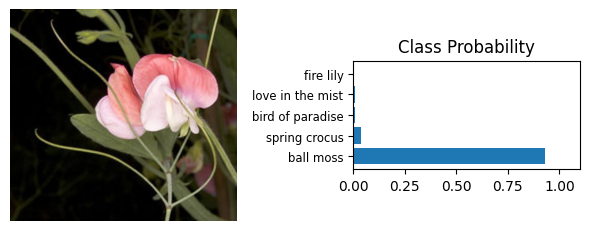

In [16]:
# TODO: Display an image along with the top 5 classe
from datetime import datetime  # Importing datetime if not already imported

def view_classify(img, ps, classes, mapper):
    """Visualizes the image and the top classes it belongs to.
    
    Args:
        img (PIL.Image): The input image to visualize.
        ps (torch.Tensor): The predicted probabilities.
        classes (list): List of class indices.
        mapper (dict): A dictionary to map class indices to class names.
    """
    start_time = datetime.now()  # Start the timer
    
    # Check if the ps tensor is empty.
    if ps.numel() == 0:
        print("Error: The probability tensor is empty!")
        return
    
    ps = ps.data.numpy().squeeze()
    
    # Set up the subplot configuration.
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=2)
    
    # Display the input image.
    ax1.imshow(img)
    ax1.axis('off')  # Turn off the axis labels
    
    # Display the horizontal bar graph of class probabilities.
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels([mapper[x] for x in classes], size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()  # Adjust spacing between subplots
    
    # Print the elapsed time.
    elapsed = datetime.now() - start_time
    print(f"Visualization completed in {elapsed.total_seconds():.2f} seconds.")
    

# Example usage:
image_path = "flowers/test/4/image_05678.jpg"
probs, classes = predict(image_path, loaded_model)
img = Image.open(image_path)

print("Initiating visualization...")
view_classify(img, torch.from_numpy(probs), classes, cat_to_name)



## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [17]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace